# RC model

As a practical example of linear state-space models, the simplified resistor-capacitor (RC) model structures are a popular choice for either parameter estimation or system identification. When written as a set of stochastic differential equations, they allow accounting for modelling approximations and offer a more reproducible parameter estimation than deterministic models that overlook modelling errors.

The experimental test cell used in this study is called the Armadillo Box. It is a demonstration building of 42 m$^2$ floor area, designed for the 2010 European Solar Decathlon by the ENSAG-GAIA-INES team. The envelope is a light wood framed construction with integrated insulation. Heating and cooling is performed by a "3 in 1" heat pump, and photovoltaic solar panels provide recharge for electric vehicles.

The building is monitored by a variety of sensors, but the present study only uses records of indoor temperature and prescribed heating power, in addition to weather data. The indoor temperature profiles used here have been averaged over several sensors distributed in the living space. The measurement time is 4 days, during which there is a 24 hour heat input.

<AxesSubplot:xlabel='Time', ylabel='indoor temperature'>

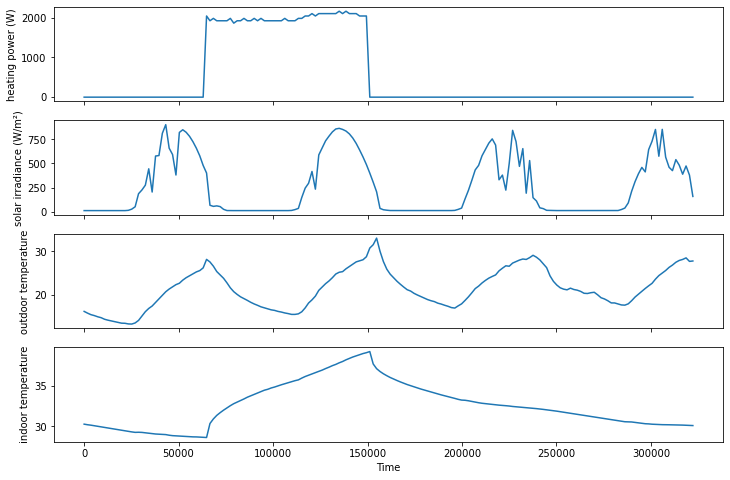

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.linalg import expm

df = pd.read_csv('data/statespace.csv')
df.set_index(df['Time'], inplace=True)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(12,8))
df['P_hea'].plot(ax=ax[0], ylabel='heating power (W)')
df['I_sol'].plot(ax=ax[1], ylabel='solar irradiance (W/m²)')
df['T_ext'].plot(ax=ax[2], ylabel='outdoor temperature')
df['T_int'].plot(ax=ax[3], ylabel='indoor temperature')

## Modelling

Consider the example of a simple building represented by a 2-resistor, 2-capacitor model structure (2R2C).

![RC model](figures/rcmodel.png)

The equations of this model are:
\begin{align}
  C_i \, \mathrm{d} T_i & = \dfrac{1}{R_i}\left(T_e-T_i\right)\mathrm{d}t + \Phi_h \, \mathrm{d}t + A_i \Phi_s \mathrm{d}t + \sigma_i \,\mathrm{d}\omega_i \\
  C_e \, \mathrm{d} T_e & = \dfrac{1}{R_i}\left(T_i-T_e\right)\mathrm{d}t + \frac{1}{R_o}\left(T_o-T_e\right)\mathrm{d}t + A_e \Phi_s \mathrm{d}t + \sigma_e \, \mathrm{d}\omega_e
\end{align}
where $T_i$, $T_e$ and $T_o$ are the indoor, envelope and outdoor temperatures. The envelope temperature is associated with the thermal mass of the opaque surfaces, and does not represent a specific coordinate within the envelope. The model has two states $T_e$ (unobserved) and $T_i$ (observed); $\Phi_h$ (W) is the indoor heating power; $\Phi_s$ (W/m$^2$) is the global horizontal solar irradiance. $R_i$ (K/W) is the thermal resistance between the indoor air temperature and the envelope, $R_e$ the resistance between the envelope and the ambient air. $C_i$ and $C_e$ (J/K) are the heat capacitances of the interior and the envelope, respectively, and $A_i$ and $A_e$ (m$^2$) are their solar gain coefficients. $\{\omega_i\}$ and $\{\omega_e\}$ are standard Wiener processes and $\sigma_i^2$ are $\sigma_e^2$ are their variances. This process noise is a way to account for modelling approximations, unrecognized inputs or noise-corrupted input measurements.

Despite its simplicity, this model structure is able to reproduce the thermal behaviour of a simple unoccupied building. The equations can be written in matrix form:
$$
\mathrm{d} \begin{bmatrix} T_i \\ T_e \end{bmatrix} = \begin{pmatrix} -\frac{1}{R_i \, C_i} & \frac{1}{R_i \, C_i} \\ \frac{1}{R_i \, C_e} & -\frac{1}{R_i \, C_e}-\frac{1}{R_e \, C_e}\end{pmatrix} \begin{bmatrix} T_i \\ T_e \end{bmatrix}\, \mathrm{d}t + \begin{pmatrix} 0 & \frac{1}{C_i} & \frac{A_i}{C_i} \\ \frac{1}{R_o \, C_e} & 0 & \frac{A_e}{C_e} \end{pmatrix} \begin{bmatrix} T_o \\ \Phi_h \\ \Phi_s \end{bmatrix} \, \mathrm{d}t + \mathbf{\sigma} \, \mathrm{d}\omega
$$
which is the dynamic model of the following stochastic state-space model, written in continuous-discrete form:
\begin{align}
\mathrm{d}\mathbf{x}(t) & = \mathbf{A}_\mathit{rc} \, \mathbf{x}(t) \, \mathrm{d}t + \mathbf{B}_\mathit{rc} \, \mathbf{u}(t)\,\mathrm{d}t + \mathbf{\sigma}_\theta \mathrm{d}\omega \\
\mathbf{y}_t & = \mathbf{C}_\theta \, \mathbf{x}_t + \mathbf{v}_t
\end{align}
The state vector $\mathbf{x}$ includes the temperatures $T_i$ and $T_e$ calculated by the model, and $\mathbf{u}=\left[T_o, \Phi_h, \Phi_s\right]$ is the input vector including boundary conditions and excitations. The second equation is the observation equation. It indicates that the measured quantity $y_t$ may be different from the output of the state equation. In our case, the observed temperature is only the first component of the state vector, and is encumbered with some measurement error $\mathbf{v}_t$. In this equation, time is noted as a subscript to indicate that observations come in a discrete sequence.

## Deterministic formulation

We first consider the most simple implementation of the model: if the modelling errors $\{\omega_i\}$ and $\{\omega_e\}$ are neglected. This is what we call a deterministic formulation, as this hypothesis is equivalent to assuming that the model is absolutely correct in reproducing the behaviour of the house.

Perhaps the easiest way to solve for the temperatures is an explicit discretisation scheme: the indoor and envelope temperatures at time $t+1$ are functions of all variables at time $t$:

\begin{align}
T_i^{(t+1)} & = T_i^{(t)} + \frac{\mathrm{d}t}{C_i} \left( \dfrac{1}{R_i}\left(T_e-T_i\right) + \Phi_h + A_i \Phi_s \right)^{(t)} \\
T_e^{(t+1)} & = T_e^{(t)} + \frac{\mathrm{d}t}{C_e} \left( \dfrac{1}{R_i}\left(T_i-T_e\right) + \frac{1}{R_o} \left(T_o-T_e\right) + A_e \Phi_s \Phi_s\right)^{(t)}
\end{align}

In Python, we define this model in a function that takes the inputs $\mathbf{u}$ as first argument, and the model parameters as other arguments. This syntax is necessary so that we can call Scipy's `curve_fit` method later. The function returns the indoor temperature, to be compared with the measurements.

In [2]:
inputs = df[['Time', 'T_ext', 'P_hea', 'I_sol']].values
output = df['T_int'].values

# Function that will calculate the indoor temperature for a given value of R and C
def simpleRC(inputs, Ri, Ro, Ci, Ce, Ai, Ae):
    
    time = inputs[:, 0]
    to   = inputs[:, 1]
    phi_h = inputs[:, 2]
    phi_s = inputs[:, 3]
    
    ti = np.zeros(len(time))
    te = np.zeros(len(time))
    
    # Initial temperatures
    ti[0] = output[0]
    te[0] = ( Ri*to[0] + Ro*ti[0] ) / (Ri + Ro)
    
    # Loop for calculating all temperatures
    for t in range(1, len(output)):
      dt = time[t] - time[t-1]
      ti[t] = ti[t-1] + dt / Ci * ( (te[t-1]-ti[t-1])/Ri + phi_h[t-1] + Ai*phi_s[t-1] )
      te[t] = te[t-1] + dt / Ce * ( (ti[t-1]-te[t-1])/Ri + (to[t-1]-te[t-1])/Ro + Ae*phi_s[t-1] )
      
    return ti

We can find the optimal parameters $\theta=(R_i, R_o, C_i, C_e, A_i, A_e)$ by minimizing the sum of squared residuals between the measured indoor temperature and the output of the function we just defined. This is equivalent to what the `curve_fit` method of Scipy does here.

The method requires initial parameter values. They can be picked by running a few simulations first until the predictions are approximately in the right range. This step is not detailed here.

In [3]:
import scipy.optimize as so

p_opt, p_cov = so.curve_fit(f=simpleRC,
                            xdata=inputs,
                            ydata=output,
                            p0=(0.01, 0.01, 1e6, 1e7, 5, 5))

# Saving results into a dataframe and displaying it
res1 = pd.DataFrame(index=['Ri', 'Ro', 'Ci', 'Ce', 'Ai', 'Ae'])
res1['avg'] = p_opt
res1['std'] = np.diag(p_cov)**0.5
print(res1)

             avg            std
Ri  4.091570e-03       0.000125
Ro  5.038526e-02       0.004552
Ci  5.344581e+06  225321.203258
Ce  1.761891e+07  841478.831398
Ai  1.861247e-01       0.055401
Ae -1.571828e+00       0.096530


The estimated parameters seem consistent with our expectations. We can compare the profile of measured indoor temperature with the output that the model predicts given the identified optimal parameters.

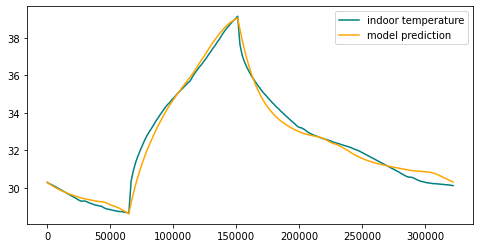

In [12]:
# Model predictions with optimal parameters
y_pred = simpleRC(inputs, *p_opt)

fig, ax = plt.subplots(figsize=(8,4))
#df['T_int'].plot(ax=ax, ylabel='indoor temperature')
ax.plot(df['T_int'], color='teal', label='indoor temperature')
ax.plot(df['Time'], y_pred, color='orange', label='model prediction')
ax.legend()

In more realistic applications, the phenomena that impact the energy balance of a building are far more complex than what such a simple model may predict. We extend the RC model structure in order to include effects of solar irradiance, ventilation, several time constants of inertia... But there is a limit to how complex a model can be made, before parameter identification becomes infeasible.

If a model does not fully describe the thermal behaviour of the building, and this discrepancy is not somehow explicitely accounted for, then the parameter estimates and predictions will be biased and unreliable. Stochastic state-space models are a way to account for modelling uncertainties and are now standard practice in the field of building energy performance assessment.

### Specification

The basics of linear state space models and the principle of the Kalman filterare explained [in this wonderful website](https://buildingenergygeeks.org/ssmprinciple.html). In the following block, a class `RC` is defined which implements these equations for any RC model. Any new RC model can then be inherited from this class, by specifying its matrices $\mathbf{A}_\mathit{rc}$, $\mathbf{A}_\mathit{rc}$ and $\mathbf{A}_\mathit{rc}$, and the covariance matrices of the modelling and measurement errors $\mathbf{Q}$ and $\mathbf{R}$.

In [5]:
class RC(object):
    """This is the generic class for any RC model structure"""

    def __init__(self):
        pass

    def discretize(self, dt):
        """ This method applies the discretisation equations shown in the previous chapter
        It is only function of the time step size dt
        """
        n = self.N_states
        # Discretisation
        F = expm(self.Ac * dt)
        G = np.dot(np.linalg.inv(self.Ac), np.dot(F - np.eye(n), self.Bc))
        H = self.Cc
        # System error covariance matrix (continuous Qc and discrete Q)
        foo = expm(np.block([[-self.Ac, self.Qc], [np.zeros(np.shape(self.Ac)), self.Ac.T]]) * dt)
        Q = np.dot(foo[n:2 * n, n:2 * n].T, foo[0:n, n:2 * n])
        # Measurement error covariance matrix (discrete)
        R = self.Rc / dt

        return F, G, H, Q, R

    def prediction(self, x_0, t, u, y=None, update=False):
        """ This method predicts the indoor temperature.
        
        If update=True, the function will apply all steps of the Kalman filter
        and return the mean state, covariances of innovations and the likelihood
        
        If update=False, the function will only predict states and their variance,
        as if no measurements were available. Use this for forecasting.
        
        x_0: initial state vector
        t: vector of time coordinates
        u: input vector
        y: measurement vector (only required if update=True)
        """

        N_time = len(t)

        # Initialisation of all arrays that will be used in the calculations
        #  Mean and variance of the states calculated at the prediction step
        x_avg_predict = np.zeros((N_time, self.N_states))
        x_var_predict = np.zeros((N_time, self.N_states, self.N_states))
        x_avg_predict[0] = x_0
        x_var_predict[0] = np.eye(self.N_states)

        x_avg_update = np.zeros((N_time, self.N_states))
        x_var_update = np.zeros((N_time, self.N_states, self.N_states))
        x_avg_update[0] = x_0
        x_var_update[0] = np.eye(self.N_states)

        epsilon = np.zeros(N_time)  # prediction errors (innovations)
        Sigma = np.zeros(N_time)  # innovation covariances
        loglike = np.zeros(N_time) # log-likelihood to be minimized

        for i in range(1, N_time):

            #  Matrices of the current time step (depend on the time step size dt)
            dt = t[i] - t[i - 1]
            F, G, H, Q, R = self.discretize(dt)

            # KALMAN 1: Prediction step
            x_avg_predict[i] = np.dot(F, x_avg_update[i-1]) + np.dot(G, u[i])
            x_var_predict[i] = np.dot(F, np.dot(x_var_update[i-1], F.T)) + Q

            if update:
                # KALMAN 2: Residuals and Kalman gain
                epsilon[i] = y[i] - np.dot(H, x_avg_predict[i])
                foo = np.dot(H, np.dot(x_var_predict[i], H.T)) + R
                Sigma[i] = foo
                K = np.dot(x_var_predict[i], np.dot(H.T, np.linalg.inv(foo)))
                loglike[i] = -0.5 * epsilon[i] ** 2 / Sigma[i] - 0.5 * Sigma[i] * 2 * np.pi
                # KALMAN 3: Update and weight
                x_avg_update[i] = x_avg_predict[i] + np.dot(K, y[i] - np.dot(H, x_avg_predict[i]))
                x_var_update[i] = x_var_predict[i] - np.dot(K, np.dot(H, x_var_predict[i]))
            else:
                x_avg_update[i] = x_avg_predict[i]
                x_var_update[i] = x_var_predict[i]

        # Returns
        if update:
        # If the Kalman update was used, return 
            X = np.dot(H, x_avg_predict.T).flatten()
            S = Sigma.flatten()
            return X, S, loglike
        else:
            X_avg = np.dot(H, x_avg_predict.T).flatten()
            X_var = np.dot(H, np.dot(x_var_predict, H.T)).flatten()
            return X_avg, X_var

The 2-resistor, 2-capacitor model drawn above is then inherited from this `RC` class. Upon definition, it takes its parameters as arguments.

In [6]:
class tite(RC):

    def __init__(self, Ri, Ro, Ci, Ce, Ai, Ae, qi, qe, r):
        """ Model inputs: ambient temperature, heating, solar irradiance"""

        # Model parameters
        self.Ri = Ri # The first resistance (K/W) of the model, on the indoor side
        self.Ro = Ro # The second resistance (K/W) of the model, on the outdoor side
        self.Ci = Ci # Heat capacity (J/K) connected to the indoor temperature
        self.Ce = Ce # Heat capacity (J/K) connected to the envelope temperature
        self.Ai = Ai # Solar aperture coefficient directed to the indoor temperature
        self.Ae = Ae # Solar aperture coefficient directed to the envelope temperature
        self.qi = qi # Standard deviation of the modelling error on Ti
        self.qe = qe # Standard deviation of the modelling error on Ti
        self.r = r   # Standard deviation of the measurement error

        # Number of states
        self.N_states = 2

        # Matrices of the continuous system
        self.Ac = np.array([[-1/(Ci*Ri), 1/(Ci*Ri)],
                            [1/(Ce*Ri), -1/(Ce*Ri) - 1/(Ce*Ro)]])
        self.Bc = np.array([[0, 1 / Ci, Ai / Ci],
                            [1/(Ce*Ro), 0, Ae/Ce]])
        self.Cc = np.array([[1, 0]])
        # System and measurement error covariance matrices
        self.Qc = np.diag([qi**2, qe**2])
        self.Rc = np.array([[r ** 2]])

Notice that this model has four additional parameters compared to the deterministic formulation above: the variance of the modelling errors on each state `qi` and `qe`, and the measurement error `r`.

### Training

We now need to find the parameters that will offer the best fit between predictions of the 2R2C model and indoor temperature measurements. We will simply use the `curve_fit` method from Scipy again.

In order to facilitate convergence, an initial parameter value is first defined. Then, the optimiser will act on an evaluation function that receives each parameter as argument, and returns the likelihood value. Some parameters are log-transformed in order to allow the search over larger scales.

In [7]:
def evaluation(df, Ri, Ro, Ci, Ce, Ai, Ae, qi, qe, r, xe0):

    # Reading the dataframe given as argument
    t = df['Time'].values
    u = df[['T_ext', 'P_hea', 'I_sol']].values
    y = df['T_int'].values

    # Model specification and initial condition
    model = tite(Ri, Ro, Ci, Ce, Ai, Ae, qi, qe, r)
    x_0 = [y[0], xe0]

    # Model prediction, without Kalman update
    X, S, L = model.prediction(x_0, t, u, y, update=True)
    
    # We only need the likelihood for the minimize method
    return X

# Curve fitting happens here. popt and pcov are the mean and covariance of parameter estimates
popt, pcov = curve_fit(evaluation,
                       xdata = df,
                       ydata = df['T_int'],
                       p0 = np.append(res1['avg'], [1e-3, 1e-3, 1e-1, 20]) ,
                       method='lm')

res2 = pd.DataFrame(index=['Ri', 'Ro', 'Ci', 'Ce', 'Ai', 'Ae', 'qi', 'qe', 'r', 'xe0'])
res2['avg'] = popt
res2['std'] = np.diag(pcov)**0.5

print(res2)

              avg            std
Ri   2.799801e-03       0.000125
Ro   1.680273e-02       0.001284
Ci   3.773714e+06  152372.536275
Ce   1.469854e+07  876101.583123
Ai   1.561966e-01       0.045091
Ae  -3.933333e-02       0.124889
qi   8.516594e-09       0.000244
qe   6.275908e-06       0.008552
r   -2.055527e-02      28.008709
xe0  2.992531e+01       0.562491


Notice that `Ae`, the solar gain coefficient on the envelope capacity, has an average value lower than its standard deviation: this parameter is likely not influential on the outcome.

### Diagnostics and residuals analysis

In order to evaluate the agreement between the fitted model and the data, let us first simply view the model output in prediction mode (without Kalman update at every time step).

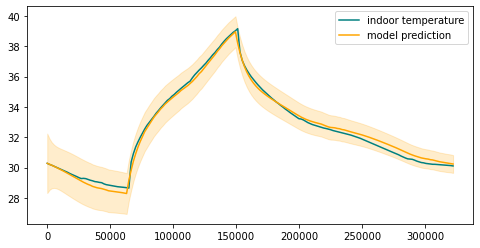

In [11]:
model_opt = tite(*res2['avg'][:-1])

# Initial states
t = df['Time'].values
u = df[['T_ext', 'P_hea', 'I_sol']].values
y = df['T_int'].values
x_0 = [y[0], res2['avg']['xe0'] ]

# Prediction without Kalman update, to be compared with the data
x_avg, x_var = model_opt.prediction(x_0, t, u, y=None, update=False)

fig, ax = plt.subplots(figsize=(8,4))
#df['T_int'].plot(ax=ax, ylabel='indoor temperature')
ax.plot(df['T_int'], color='teal', label='indoor temperature')
ax.plot(df['Time'], x_avg, color='orange', label='model prediction')
ax.fill_between(df['Time'], x_avg-1.96*np.sqrt(x_var), x_avg+1.96*np.sqrt(x_var), color='orange', alpha=0.2)
ax.legend()

The model fits the data well. The 95% confidence intervals are relatively narrow, indicating a good confidence in the prediction.

Another important criterion on which to judge the fitted model is the autocorrelation function (ACF) of the one-step ahead prediction residuals. In order to view these residuals, the prediction function should be run with the Kalman updating switched on, so that the states it returns are one-step ahead predictions only.

<BarContainer object of 50 artists>

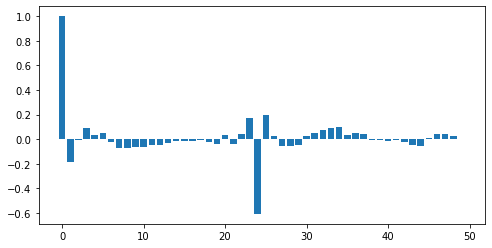

In [14]:
X, S, L = model_opt.prediction(x_0, t, u, y, update=True)

# eps_ are the one-step ahead prediction residuals
eps_ = y - X
# Let's only take every other value, so that we have time lags of one hour.
eps_ = eps_[::2]

# Correlation function of two time series. Can be used for the autocorrelation of a single time series
def crosscorrelation(x, u):
    """
    http://stackoverflow.com/q/14297012/190597
    http://en.wikipedia.org/wiki/Autocorrelation#Estimation
    """
    n = len(x)
    x = x-x.mean()
    u = u-u.mean()
    r = np.correlate(x, u, mode = 'full')[-n:]
    return r/(x.std()*u.std()*(np.arange(n, 0, -1)))

# Autocorrelation of the residuals (only keeping the first 50 lags)
ACF = crosscorrelation(eps_, eps_)[0:50]
lags = np.linspace(0,49,50)

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(lags, ACF)

The residuals are low, except from one important peak at 24h lag. This suggests that an important influence occuring with a period of 24 hours has been insufficiently accounted for by the model.